<a href="https://colab.research.google.com/github/Sofigam00s/Procesamiento-del-habla-IA/blob/main/NLP_Gamallo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP3 desafío de procesamiento de textos por postas


# FORMA DE TRABAJO

**PRIMERO LEA EL SIGUIENTE DOCUMENTO**

La forma de trabajo se explica en el siguiente documento.

https://docs.google.com/document/d/1Yvd9_326qb6imzx-vC16UmGhXGd5NeJEyvr176-Oknc/edit?usp=sharing

Lea primero el documento **ANTES** de proceder con el notebook.

# 1 - Preparación de datos


## 1A - Configuración del entorno

* Instalar las bibliotecas necesarias para el procesamiento de texto
* Importar las bibliotecas requeridas
* Verificar versiones y disponibilidad


In [ ]:
!pip install PyPDF2

In [ ]:
import requests
import PyPDF2
import unicodedata
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import spacy


In [ ]:
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 24.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## 1B - Descarga del archivo PDF (Valentina Krabbe)
* Descargar el PDF del libro "El gaucho Martín Fierro" desde el enlace proporcionado
* Verificar que el archivo se descargó correctamente
* Guardar en una variable la ruta al archivo

Se utilizó un prompt de Copilot: como descargar el pdf de un link y guardar su ruta en python.

También encontré otras referencias en internet pero con codigos distintos:

https://stackoverflow.com/questions/34503412/download-and-save-pdf-file-with-python-requests-module

https://www.geeksforgeeks.org/python/downloading-pdfs-with-python-using-requests-and-beautifulsoup/

In [ ]:
# Primero se guarda el link de una variable para poder hacer su extracción
url = "https://www.argentina.gob.ar/sites/default/files/hernandez_jose_-_el_gaucho_martin_fierro.pdf"


In [ ]:
# Se usa otra variable para deifnir el nombre del pdf, en este caso es ''martin_fierro.pdf''
ruta_pdf = "martin_fierro.pdf"


In [ ]:
# Aca es donde se hace la petición al sitio web para poder obtener el pdf
respuesta = requests.get(url)

In [ ]:
# Se verifica que el pdf se haya descargado correctamente; 200 es un código numérico de http que indica que todo salió bien (es como el código 404 de error)
if respuesta.status_code == 200:
    with open(ruta_pdf, "wb") as archivo:
        archivo.write(respuesta.content)
    print("Descarga completada exitosamente.")
else:
    print(f"Error al descargar el archivo: {respuesta.status_code}")


Descarga completada exitosamente.


In [ ]:
ruta_pdf

'martin_fierro.pdf'

# 2 - Extracción y limpieza de texto

## 2A - Extracción de texto desde PDF
* Abrir el archivo PDF
* Extraer el texto completo
* Guardar el resultado en una variable `texto_completo`
* Mostrar las primeras 500 palabras

In [ ]:
# Abrimos el PDF en modo lectura binaria
with open(ruta_pdf, 'rb') as archivo:
    lector = PyPDF2.PdfReader(archivo)
    texto_completo = ''  # Donde se acumulará el texto

    # Recorremos todas las páginas
    for pagina in lector.pages:
        texto = pagina.extract_text()
        if texto:  # A veces puede devolver None
            texto_completo += texto + '\n'

# Dividimos por palabras y mostramos las primeras 500
palabras = texto_completo.split()
primeras_500 = ' '.join(palabras[:500])
print(primeras_500)

Recursos de dominio públicoEl gaucho Martín Fierro José Hernández José Hernández El Gaucho Martín Fierro José Hernández (1834 - 1886) Imágenes de dominio público. Fuente: http://upload.wikimedia.org/wikipedia/commons/8/8c/Jos%C3%A9_Hern%C3%A1ndez_Argentino.jpghttp://upload.wikimedia.org/wikipedia/commons/3/30/El_Gaucho_Mart%C3%ADn_Fierro_2.jpg http://upload.wikimedia.org/wikipedia/commons/4/44/El_Gaucho_Mart%C3%ADn_Fierro_3.jpg http://upload.wikimedia.org/wikipedia/commons/4/47/El_Gaucho_Mart%C3%ADn_Fierro_1.jpg Página 2 El Gaucho Martín Fierro I Aquí me pongo a cantar al compás de la vigüela, que el hombre que lo desvela una pena estrordinaria, como la ave solitaria con el cantar se consuela. Pido a los santos del cielo que ayuden mi pensamiento: les pido en este momento que voy a cantar mi historia me refresquen la memoria y aclaren mi entendimiento. Vengan santos milagrosos, vengan todos en mi ayuda, que la lengua se me añuda y se me turba la vista; pido a mi Dios que me asista en u

## 2B - Identificación del contenido relevante
* Analizar el texto para determinar dónde comienza y termina el contenido del libro
* Identificar y eliminar índices, prólogos, anexos
* Documentar los criterios utilizados para esta selección
* Guardar en `texto_libro` solo el contenido del libro

In [ ]:
def normalizar(texto):
    # Pasa todo a minúsculas
    texto = texto.lower()
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')
    return texto

# Normalizamos el texto
texto_normalizado = normalizar(texto_completo)

# Obtenemos solo el texto que comienza y termina con los versos clave
inicio_patron = r'aqui me pongo a cantar'
fin_patron = r'males que conocen todos\s+pero que naides conto'

inicio = re.search(inicio_patron, texto_normalizado)
fin = re.search(fin_patron, texto_normalizado)

if inicio and fin:
    texto_libro = texto_completo[inicio.start():fin.end()]

    # Elimina líneas tipo "Página 3", "Página 15", etc.
    texto_libro = re.sub(r'^\s*Página\s+\d+\s*$', '', texto_libro, flags=re.MULTILINE)

    # Elimina títulos de cantos (números romanos con o sin texto)
    texto_libro = re.sub(r'^\s*[IVXLCDM]+\s*(CRUZ|MART[IÍ]N\s+FIERRO)?\s*$', '', texto_libro, flags=re.MULTILINE)
else:
    print("No se pudo localizar el inicio o fin del texto del libro.")

In [ ]:
print(texto_libro[:300])

Aquí me pongo a cantar
al compás de la vigüela,
que el hombre que lo desvela
una pena estrordinaria,
como la ave solitaria
con el cantar se consuela.
Pido a los santos del cielo
que ayuden mi pensamiento:
les pido en este momento
que voy a cantar mi historia
me refresquen la memoria
y aclaren mi ent


## 2C - Limpieza del texto
* Eliminar caracteres especiales y no deseados
* Normalizar espacios, saltos de línea y puntuación
* Convertir a minúsculas si es necesario
* Guardar en `texto_limpio` el resultado final

In [ ]:
def limpiar_martin_fierro(texto):
      # Normalizar a NFKD para separar las letras de los acentos
    texto = unicodedata.normalize("NFKD", texto)

    # Eliminar los caracteres de combinación (acentos)
    texto = ''.join([c for c in texto if not unicodedata.combining(c)])

    # Pasar todo a minúsculas
    texto = texto.lower()

    # Eliminar signos de puntuación y otros símbolos
    texto = re.sub(r'[¡!¿?\'\"“”‘’«»…]', '', texto)

    # Eliminar cualquier caracter que no sea letra sin tilde o espacio
    texto = re.sub(r'[^a-zñ\s]', '', texto)

    # Reemplazar múltiples espacios por uno solo
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto

In [ ]:
texto_limpio = limpiar_martin_fierro(texto_libro)
texto_limpio[:400]

'aqui me pongo a cantar al compas de la viguela que el hombre que lo desvela una pena estrordinaria como la ave solitaria con el cantar se consuela pido a los santos del cielo que ayuden mi pensamiento les pido en este momento que voy a cantar mi historia me refresquen la memoria y aclaren mi entendimiento vengan santos milagrosos vengan todos en mi ayuda que la lengua se me anuda y se me turba la '

# 3 - Análisis de Stop-words

## 3A - Identificación de stop-words
* Tokenizar el texto limpio
* Utilizar recursos de NLTK o SpaCy para identificar stop-words en español
* Crear una lista `stop_words` con todas las stop-words identificadas
* Mostrar las primeras 20 stop-words

In [ ]:
# Descargar el tokenizador y las stopwords
nltk.download('punkt')
nltk.download('stopwords')
# Descargar el recurso punkt_tab para español
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Tokenizar el texto limpio
tokens = word_tokenize(texto_limpio, language='spanish')

print(tokens[:20])

['aqui', 'me', 'pongo', 'a', 'cantar', 'al', 'compas', 'de', 'la', 'viguela', 'que', 'el', 'hombre', 'que', 'lo', 'desvela', 'una', 'pena', 'estrordinaria', 'como']


In [ ]:
# Obtener la lista de stop-words en español
stop_words = set(stopwords.words('spanish'))

# Filtrar tokens que son stop-words
stop_words = [palabra for palabra in tokens if palabra.lower() in stop_words]

# Mostrar las primeras 20 stop-words encontradas en el texto
print(stop_words[:20])


['me', 'a', 'al', 'de', 'la', 'que', 'el', 'que', 'lo', 'una', 'como', 'la', 'con', 'el', 'se', 'a', 'los', 'del', 'que', 'mi']


## 3B - Análisis de frecuencia de stop-words
* Contar la frecuencia de cada stop-word en el texto
* Crear un DataFrame con las stop-words y sus frecuencias
* Ordenar por frecuencia descendente
* Mostrar las 10 stop-words más frecuentes

In [ ]:
# Cuenta la frecuencia de las stopwords
frecuencia_stopwords = Counter(stop_words)

In [ ]:
# Crea un DataFrame con las stopwords y sus frecuencias
df_stopwords = pd.DataFrame(list(frecuencia_stopwords.items()), columns=['Stopword', 'Frecuencia'])

In [ ]:
# Se ordenan las stopwords por frecuencia descendiente
df_stopwords = df_stopwords.sort_values(by='Frecuencia', ascending=False)

In [ ]:
# Se muestran las 10 stopwords más frecuentes
df_stopwords.head(10)


,Stopword,Frecuencia
5,que,460
18,y,441
6,el,388
4,la,309
3,de,274
1,a,256
16,en,241
0,me,231
23,no,200
31,un,186


## 3C - Visualización de stop-words
* Crear un gráfico de barras con las 15 stop-words más frecuentes
* Añadir título y etiquetas a los ejes
* Personalizar el aspecto visual del gráfico
* Guardar la figura resultante

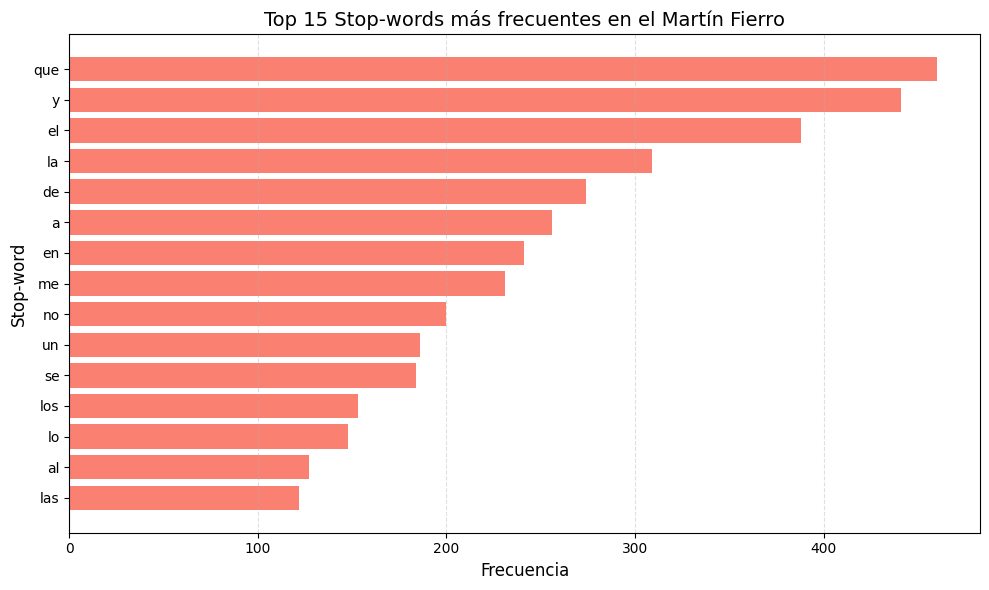

In [ ]:
# Seleccionamos las 15 stopwords más frecuentes
top15 = df_stopwords.head(15)

# Creamos el gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(top15['Stopword'], top15['Frecuencia'], color='salmon')
plt.xlabel('Frecuencia', fontsize=12)
plt.ylabel('Stop-word', fontsize=12)
plt.title('Top 15 Stop-words más frecuentes en el Martín Fierro', fontsize=14)
plt.gca().invert_yaxis()  # Para que la más frecuente aparezca arriba
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()

# Guardamos la figura como archivo PNG
plt.savefig("stopwords_frecuentes.png")
plt.show()


# 4 - Análisis de vocabulario

## 4A - Extracción del vocabulario completo
* Tokenizar el texto limpio
* Eliminar las stop-words identificadas en el punto 3
* Crear una lista `vocabulario_completo` con todos los tokens resultantes
* Mostrar los primeros 30 elementos

In [ ]:
# Cargamos el modelo en español
nlp = spacy.load('es_core_news_sm')

In [ ]:
# Procesamos el texto limpio
doc = nlp(texto_limpio)
doc[:30]

aqui me pongo a cantar al compas de la viguela que el hombre que lo desvela una pena estrordinaria como la ave solitaria con el cantar se consuela pido a

In [ ]:
# Filtramos: eliminamos stop-words y palabras que no sean alfabéticas
vocabulario_completo = [token.text for token in doc if not token.is_stop and token.is_alpha]

In [ ]:
# Mostramos los primeros 30
print(vocabulario_completo[:30])

['pongo', 'cantar', 'compas', 'viguela', 'hombre', 'desvela', 'pena', 'estrordinaria', 'ave', 'solitaria', 'cantar', 'consuela', 'pido', 'santos', 'cielo', 'ayuden', 'pensamiento', 'pido', 'momento', 'cantar', 'historia', 'refresquen', 'memoria', 'aclaren', 'entendimiento', 'vengan', 'santos', 'milagrosos', 'vengan', 'ayuda']


## 4B - Análisis del vocabulario único
* Crear un conjunto con palabras únicas del vocabulario
* Almacenar en `vocabulario_unico`
* Mostrar la cantidad de palabras únicas vs. total de palabras
* Calcular la diversidad léxica (palabras únicas / total)

In [ ]:
# Se crea la variable vocabulario_unico donde se guardan solo los tokens únicos del vocabulario completo
vocabulario_unico = set(vocabulario_completo)

In [ ]:
print('Cantidad de palabras únicas:', len(vocabulario_unico))

Cantidad de palabras únicas: 2518


In [ ]:
print('Cantidad de palabras totales:', len(vocabulario_completo))

Cantidad de palabras totales: 4658


In [ ]:
diversidad_lexica = len(vocabulario_unico) / len(vocabulario_completo)
print("Diversidad léxica:", diversidad_lexica)

Diversidad léxica: 0.5405753542292829


## 4C - Frecuencia del vocabulario
* Contar la frecuencia de cada palabra en el vocabulario
* Crear un DataFrame con las palabras y sus frecuencias
* Ordenar por frecuencia descendente
* Mostrar las 20 palabras más frecuentes

In [ ]:
# Contamos la frecuencia de cada palabra en el vocabulario
frecuencias = Counter(vocabulario_completo)

In [ ]:
# Creamos un DataFrame a partir del conteo
df_vocabulario = pd.DataFrame(frecuencias.items(), columns=['Palabra', 'Frecuencia'])

In [ ]:
# Ordenamos de mayor a menor
df_vocabulario = df_vocabulario.sort_values(by='Frecuencia', ascending=False)

In [ ]:
# Mostramos las 20 palabras más frecuentes
df_vocabulario.head(20)

,Palabra,Frecuencia
202,pa,66
134,gaucho,55
316,ansi,25
4,hombre,24
98,naides,20
52,dende,20
427,mesmo,19
1004,suerte,18
223,tenia,18
29,dios,18


## 4D - Sustantivos

Utilizando resultados anteriores:
* muestre los sustantivos (NOUN, PROPNOUN) del vocabulario más usados y la cantidad de veces que aparecen.
* elabore un diagrama de gráficos de barra -> Seleccioné al azar los 20 sustantivos más utilizados:

In [ ]:
# Reprocesamos los tokens de vocabulario_completo con SpaCy
tokens_spacy = [token for token in nlp(" ".join(vocabulario_completo))]

In [ ]:
# Filtramos solo sustantivos
sustantivos_vocabulario = [t.text.lower() for t in tokens_spacy if t.pos_ in ['NOUN', 'PROPN'] and t.is_alpha]

In [ ]:
# Contamos frecuencias
frecuencia_sustantivos_vocab = Counter(sustantivos_vocabulario)
df_sustantivos_vocab = pd.DataFrame(frecuencia_sustantivos_vocab.items(), columns=['Sustantivo', 'Frecuencia']).sort_values(by='Frecuencia', ascending=False)

In [ ]:
# Mostramos los 20 primeros
print(df_sustantivos_vocab.head(20))

    Sustantivo  Frecuencia
2       hombre          24
113     gaucho          23
171      mesmo          19
427     suerte          17
78       gente          16
83        vida          15
93       tenia          13
17     ocasion          13
95       mujer          13
33      tierra          13
106       cosa          12
16        dios          12
130      noche          12
187      males          11
127      campo          10
45        mano           9
90      tiempo           9
28       mundo           9
94       hijos           9
859       cruz           9


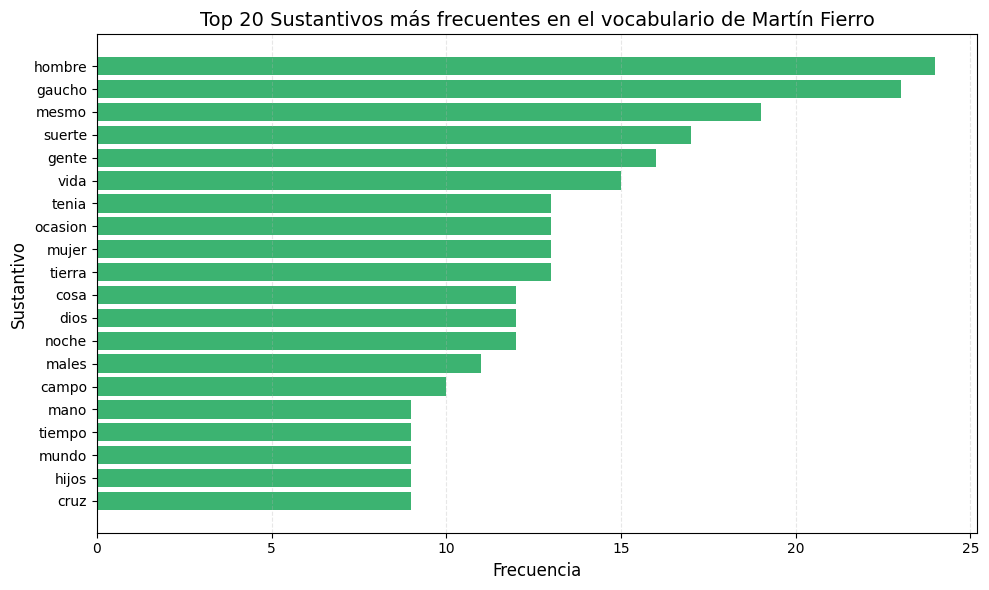

In [ ]:
# Tomamos los 20 sustantivos más frecuentes
top20_sustantivos = df_sustantivos_vocab.head(20)

# Creamos el gráfico
plt.figure(figsize=(10, 6))
plt.barh(top20_sustantivos['Sustantivo'], top20_sustantivos['Frecuencia'], color='mediumseagreen')
plt.xlabel('Frecuencia', fontsize=12)
plt.ylabel('Sustantivo', fontsize=12)
plt.title('Top 20 Sustantivos más frecuentes en el vocabulario de Martín Fierro', fontsize=14)
plt.gca().invert_yaxis()  # El más frecuente arriba
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("sustantivos_frecuentes.png")
plt.show()


## 4E- Lugares

De lo obtenido de 4B y 4D.

* Usar las bibliotecas spacy o nltk para identificar lugares o locaciones que mencione el libro.
* Muestre el listado.
* Realice una tabla indicando los lugares más mencionados

In [ ]:
# Extraemos entidades de tipo LOC (ubicaciones) y GPE (entidades geopolíticas como países, provincias, pueblos)
lugares = [ent.text for ent in doc.ents if ent.label_ in ["LOC", "GPE"]]

In [ ]:
# Contamos frecuencia
frecuencia_lugares = Counter([lugar.strip().lower() for lugar in lugares])

In [ ]:
# Creamos el DataFrame
df_lugares = pd.DataFrame(frecuencia_lugares.items(), columns=["Lugar", "Frecuencia"])
df_lugares = df_lugares.sort_values(by="Frecuencia", ascending=False)

In [ ]:
# Mostramos el top 15 de lugares más mencionados
print(df_lugares.head(15))

        Lugar  Frecuencia
0   la tierra           2
1        aqui           2
3       china           2
5       salia           2
2     remolon           1
4     palermo           1
6    enancaos           1
7       mojon           1
8      creiba           1
9       virtu           1
10    guayaca           1
11  espantaos           1
12    ginebra           1
13     hollin           1
14       lima           1


## 4F- Personajes

De lo obtenido de 4B, 4D, 4E.

* Usar las bibliotecas spacy o nltk para identificar personajes (personas, o sustantivos propios).
¿ Puede distinguir a los personajes del libro? ¿Podría realizar un preprocesamiento para obtenerlos?

* Si a un personaje se lo refiere de más de una manera, liste todas sus referencias.

In [ ]:
# Extraer entidades tipo PERSON
personajes = [ent.text.strip() for ent in doc.ents if ent.label_ == "PER"]

In [ ]:
# Contar frecuencias
frecuencia_personajes = Counter([p.lower() for p in personajes])

In [ ]:
# Mostrar los más frecuentes
df_personajes = pd.DataFrame(frecuencia_personajes.items(), columns=["Nombre", "Frecuencia"])
df_personajes = df_personajes.sort_values(by="Frecuencia", ascending=False)
print(df_personajes.head(10))


             Nombre  Frecuencia
11             alli           3
4            naides           2
10           cristo           2
0     martin fierro           1
1      gloria labra           1
2            letrao           1
6            habian           1
7      habian estao           1
3             peleo           1
5   habian manotiao           1


In [ ]:
#Busco los nompres propios con 'PRONPN'
nombres_propios = [token.text for token in doc if token.pos_ == 'PROPN']
print(nombres_propios)

['martin', 'fierro', 'mi', 'letrao', 'naides', 'naides', 'dios', 'alvertido', 'junta', 'vivia', 'tenia', 'dia', 'pellon', 'pion', 'dios', 'dia', 'cair', 'mas', 'infeliz', 'tenia', 'via', 'yel', 'vivia', 'goyete', 'via', 'aura', 'principia', 'batallon', 'santos', 'sosegao', 'vivia', 'monton', 'votacion', 'dia', 'esposicion', 'redondo', 'jue', 'tenia', 'jergas', 'bozal', 'maniador', 'canton', 'raton', 'tenia', 'segun', 'dia', 'palermo', 'canton', 'afan', 'dentra', 'mata', 'mata', 'enderiesa', 'canton', 'boton', 'malon', 'estao', 'maiz', 'sono', 'habia', 'jue', 'pucha', 'aflicion', 'acabau', 'cristiano', 'dios', 'jue', 'quedo', 'mojon', 'mata', 'chorizo', 'horror', 'vida', 'yesca', 'poncho', 'jue', 'canton', 'aijuna', 'nandu', 'virtu', 'cerda', 'oracion', 'entripao', 'comiendome', 'aura', 'rosas', 'habia', 'canton', 'malon', 'fresca', 'jue', 'vivoras', 'hagarto', 'despacito', 'jusil', 'juncion', 'quedo', 'nacion', 'canton', 'sali', 'fi', 'algun', 'compasion', 'algun', 'jogon', 'carta', 't

In [ ]:
#Cuento la feecuencia de los nombres propios
frec_nombres = Counter(nombres_propios)

#Muestro los más comunes
print("Nombres propios más comunes:")
for nombre, freq in frec_nombres.most_common(15):
    print(f"{nombre}: {freq}")

Nombres propios más comunes:
habia: 7
tenia: 6
jue: 6
canton: 6
cruz: 6
algun: 5
dia: 4
sali: 4
naides: 3
dios: 3
vivia: 3
mata: 3
aflicion: 3
poncho: 3
facon: 3


In [ ]:
'''pip install flair'''


'pip install flair'

In [ ]:
'''from flair.models import SequenceTagger
from flair.data import Sentence

# Cargar el modelo de reconocimiento de entidades
tagger = SequenceTagger.load("flair/ner-spanish-large")'''


'from flair.models import SequenceTagger\nfrom flair.data import Sentence\n\n# Cargar el modelo de reconocimiento de entidades\ntagger = SequenceTagger.load("flair/ner-spanish-large")'

In [ ]:
'''# Dividir el texto en fragmentos (por párrafos o líneas)
fragmentos = texto_limpio.split('\n')

# Listar entidades tipo PERSON
personajes_flair = []

for frag in fragmentos:
    if frag.strip():
        sentence = Sentence(frag)
        tagger.predict(sentence)
        personajes_flair.extend([ent.text for ent in sentence.get_spans('ner') if ent.get_label("ner").value == "PER"])

# Contar la frecuencia de aparición de cada personaje
frecuencia_personajes_flair = Counter([p.lower() for p in personajes_flair])
df_personajes_flair = pd.DataFrame(frecuencia_personajes_flair.items(), columns=["Personaje", "Frecuencia"]).sort_values(by="Frecuencia", ascending=False)

# Mostrar los personajes más frecuentes
print(df_personajes_flair.head(10))'''


'# Dividir el texto en fragmentos (por párrafos o líneas)\nfragmentos = texto_limpio.split(\'\n\')\n\n# Listar entidades tipo PERSON\npersonajes_flair = []\n\nfor frag in fragmentos:\n    if frag.strip():\n        sentence = Sentence(frag)\n        tagger.predict(sentence)\n        personajes_flair.extend([ent.text for ent in sentence.get_spans(\'ner\') if ent.get_label("ner").value == "PER"])\n\n# Contar la frecuencia de aparición de cada personaje\nfrecuencia_personajes_flair = Counter([p.lower() for p in personajes_flair])\ndf_personajes_flair = pd.DataFrame(frecuencia_personajes_flair.items(), columns=["Personaje", "Frecuencia"]).sort_values(by="Frecuencia", ascending=False)\n\n# Mostrar los personajes más frecuentes\nprint(df_personajes_flair.head(10))'

## 4G - VERBOS

Usando los resultados anteriores, muestre los verbos más utilizados.

* Preprocesamiento: ¿cuál pre procesamiento realizaría para quedarse con la raiz del verbo o su infinitivo?
* Muestre los verbos más utilizados. Realice un gráfico

In [ ]:
# Extraemos verbos en infinitivo (lemas)
verbos = [token.lemma_ for token in doc if token.pos_ == "VERB" and token.is_alpha and not token.is_stop]

# Contamos frecuencia
frecuencia_verbos = Counter(verbos)
df_verbos = pd.DataFrame(frecuencia_verbos.items(), columns=["Verbo", "Frecuencia"]).sort_values(by="Frecuencia", ascending=False)

# Mostramos los 20 más frecuentes
print(df_verbos.head(20))


      Verbo  Frecuencia
46    andar          34
12      ver          33
25    venir          30
107    ansi          24
13   querer          22
1    cantar          21
44    salir          21
18    pasar          21
190   decir          20
160   dejar          18
116     dar          17
152  quedar          16
17    andir          15
143  mandar          15
21   dendir          13
27   faltar          13
55    vivir          13
144   echar          12
0     poner          12
192   hacer          12


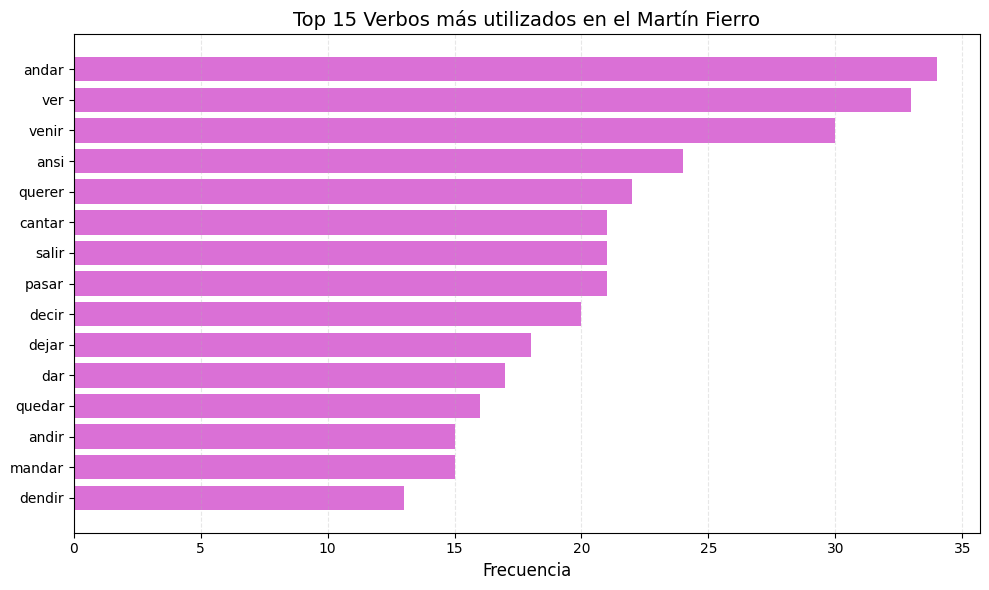

In [ ]:
# Seleccionamos top 15
top15 = df_verbos.head(15)

# Gráfico de barras horizontales
plt.figure(figsize=(10, 6))
plt.barh(top15['Verbo'], top15['Frecuencia'], color='orchid')
plt.xlabel("Frecuencia", fontsize=12)
plt.title("Top 15 Verbos más utilizados en el Martín Fierro", fontsize=14)
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig("verbos_frecuentes.png")
plt.show()


# 5 - Creación del corpus

## 5A - Segmentación en estrofas (Garcia Alves de Borba, Juan Andrés)
* Definir criterios para identificar estrofas en el texto
* Crear una función que separe el texto en estrofas
* Aplicarla al texto limpio del libro
* Guardar en `lista_estrofas` el resultado

In [ ]:
# Paso 1: texto limpio pero estructuralmente intacto
texto_visible = texto_completo.lower()  # o con normalización leve pero manteniendo saltos

# Paso 2: identificar los límites
inicio = re.search(inicio_patron, texto_visible)
fin = re.search(fin_patron, texto_visible)

# Paso 3: extraer del texto original sin alterar saltos
if inicio and fin:
    texto_libro = texto_completo[inicio.start():fin.end()]

texto_libro

'Aquí me pongo a cantar\nal compás de la vigüela,\nque el hombre que lo desvela\nuna pena estrordinaria,\ncomo la ave solitaria\ncon el cantar se consuela.\nPido a los santos del cielo\nque ayuden mi pensamiento:\nles pido en este momento\nque voy a cantar mi historia\nme refresquen la memoria\ny aclaren mi entendimiento.\nVengan santos milagrosos,\nvengan todos en mi ayuda,\nque la lengua se me añuda\ny se me turba la vista;\npido a mi Dios que me asista\nen una ocasión tan ruda.\nYo he visto muchos cantores,\ncon famas bien otenidas\ny que después de alquiridas\nno las quieren sustentar:\nparece que sin largar\nse cansaron en partidas.\nMas ande otro criollo pasa\nMartín Fierro ha de pasar;\nnada lo hace recular,\nni las fantasmas lo espantan,\ny dende que todos cantan\nyo también quiero cantar.\nCantando me he de morir,\ncantando me han de enterrar,\ny cantando he de llegar\nal pie del Eterno Padre;\ndende el vientre de mi madre\nvine a este mundo a cantar.\nQue no se trabe mi lengu

In [ ]:
def limpiar_martin_fierro_v2(texto):
      # Normalizar a NFKD para separar las letras de los acentos
    texto = unicodedata.normalize("NFKD", texto)

    # Eliminar los caracteres de combinación (acentos)
    texto = ''.join([c for c in texto if not unicodedata.combining(c)])

    # Pasar todo a minúsculas
    texto = texto.lower()

    # Eliminar signos de puntuación y otros símbolos
    texto = re.sub(r'[¡!¿?\'\"“”‘’«»…]', '', texto)

		# Eliminar los 3 puntos suspensivos al final de las oraciones
    texto = re.sub(r'\.\.\.', '', texto)  									# <-- Agregué esta expresión regular para eliminar los puntos suspensivos

    # Eliminar cualquier caracter que no sea letra sin tilde o espacio
    texto = re.sub(r'[^a-zñ\s.]', '', texto)								# <-- Cambié la expresión regular previa para permitir los puntos

    # Reemplazar múltiples espacios por uno solo
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto

In [ ]:
texto_limpio = limpiar_martin_fierro_v2(texto_libro)
texto_limpio[:200]

'aqui me pongo a cantar al compas de la viguela que el hombre que lo desvela una pena estrordinaria como la ave solitaria con el cantar se consuela. pido a los santos del cielo que ayuden mi pensamient'

In [ ]:
def separar_en_estrofas(texto):
	estrofas = []

	for estrofa in texto.split('.'):
		estrofas.append(estrofa.strip())

	return estrofas

In [ ]:
lista_estrofas = separar_en_estrofas(texto_limpio)

lista_estrofas[:20]
# lista_estrofas  	# descomentar para ver todas las estrofas

['aqui me pongo a cantar al compas de la viguela que el hombre que lo desvela una pena estrordinaria como la ave solitaria con el cantar se consuela',
 'pido a los santos del cielo que ayuden mi pensamiento les pido en este momento que voy a cantar mi historia me refresquen la memoria y aclaren mi entendimiento',
 'vengan santos milagrosos vengan todos en mi ayuda que la lengua se me anuda y se me turba la vista pido a mi dios que me asista en una ocasion tan ruda',
 'yo he visto muchos cantores con famas bien otenidas y que despues de alquiridas no las quieren sustentar parece que sin largar se cansaron en partidas',
 'mas ande otro criollo pasa martin fierro ha de pasar nada lo hace recular ni las fantasmas lo espantan y dende que todos cantan yo tambien quiero cantar',
 'cantando me he de morir cantando me han de enterrar y cantando he de llegar al pie del eterno padre dende el vientre de mi madre vine a este mundo a cantar',
 'que no se trabe mi lengua ni me falte la palabra el can

## 5B - Limpieza de estrofas
Revisar el listado de estrofas y el preprocesamiento anterior.

* Eliminar estrofas vacías.
* Normalizar formato de cada estrofa
* Verificar consistencia del corpus
* Guardar en `corpus_limpio` el resultado final


In [ ]:
import re
import unicodedata

def normalizar_estrofa(estrofa):
    # Pasa todo a minúsculas
    estrofa = estrofa.lower()

    # Elimina acentos
    estrofa = unicodedata.normalize("NFKD", estrofa)
    estrofa = ''.join(c for c in estrofa if not unicodedata.combining(c))

    # Elimina signos de puntuación innecesarios (excepto puntos si querés conservarlos)
    estrofa = re.sub(r'[¡!¿?\"“”‘’«»]', '', estrofa)

    # Reemplaza múltiples espacios por uno
    estrofa = re.sub(r'\s+', ' ', estrofa).strip()

    return estrofa


In [ ]:
# Limpiamos las estrofas
corpus_limpio = [
    normalizar_estrofa(e) for e in lista_estrofas
    if e and e.strip()  # Elimina vacías
]


In [ ]:
print(f"Cantidad final de estrofas limpias: {len(corpus_limpio)}")

# Mostrar ejemplo de estrofas limpias
for i, e in enumerate(corpus_limpio[:9], 1):
    print(f"\nEstrofa {i}:\n{e}")


Cantidad final de estrofas limpias: 434

Estrofa 1:
aqui me pongo a cantar al compas de la viguela que el hombre que lo desvela una pena estrordinaria como la ave solitaria con el cantar se consuela

Estrofa 2:
pido a los santos del cielo que ayuden mi pensamiento les pido en este momento que voy a cantar mi historia me refresquen la memoria y aclaren mi entendimiento

Estrofa 3:
vengan santos milagrosos vengan todos en mi ayuda que la lengua se me anuda y se me turba la vista pido a mi dios que me asista en una ocasion tan ruda

Estrofa 4:
yo he visto muchos cantores con famas bien otenidas y que despues de alquiridas no las quieren sustentar parece que sin largar se cansaron en partidas

Estrofa 5:
mas ande otro criollo pasa martin fierro ha de pasar nada lo hace recular ni las fantasmas lo espantan y dende que todos cantan yo tambien quiero cantar

Estrofa 6:
cantando me he de morir cantando me han de enterrar y cantando he de llegar al pie del eterno padre dende el vientre de mi ma

# 6 - N-gramas

## 6A - Extracción de bigramas (nombre y apellido de quien resuelve)
* Crear una función para extraer bigramas del texto limpio
* Generar la lista completa de bigramas
* Mostrar los 20 bigramas más frecuentes (sin filtrar)
* Visualizar en un gráfico de barras


In [ ]:
texto_limpio

'aqui me pongo a cantar al compas de la viguela que el hombre que lo desvela una pena estrordinaria como la ave solitaria con el cantar se consuela. pido a los santos del cielo que ayuden mi pensamiento les pido en este momento que voy a cantar mi historia me refresquen la memoria y aclaren mi entendimiento. vengan santos milagrosos vengan todos en mi ayuda que la lengua se me anuda y se me turba la vista pido a mi dios que me asista en una ocasion tan ruda. yo he visto muchos cantores con famas bien otenidas y que despues de alquiridas no las quieren sustentar parece que sin largar se cansaron en partidas. mas ande otro criollo pasa martin fierro ha de pasar nada lo hace recular ni las fantasmas lo espantan y dende que todos cantan yo tambien quiero cantar. cantando me he de morir cantando me han de enterrar y cantando he de llegar al pie del eterno padre dende el vientre de mi madre vine a este mundo a cantar. que no se trabe mi lengua ni me falte la palabra el cantar mi gloria labra

In [ ]:
# Tokenizamos el texto limpio entero
tokens = word_tokenize(texto_limpio.lower())

In [ ]:
from nltk.util import bigrams
# Generamos bigramas
bigrs = list(bigrams(tokens))

# Contamos frecuencia
conteo = Counter(bigrs)

# Extraemos top 20
top20 = conteo.most_common(20)


In [ ]:
for par, freq in top20:
    print(f"{' '.join(par)}: {freq}")


. y: 65
en la: 36
que el: 33
a la: 31
en el: 30
. yo: 29
que no: 28
el gaucho: 20
de un: 19
y me: 19
que se: 19
de la: 18
se me: 18
con el: 17
a los: 17
y que: 17
no se: 17
con la: 17
. no: 17
. el: 16


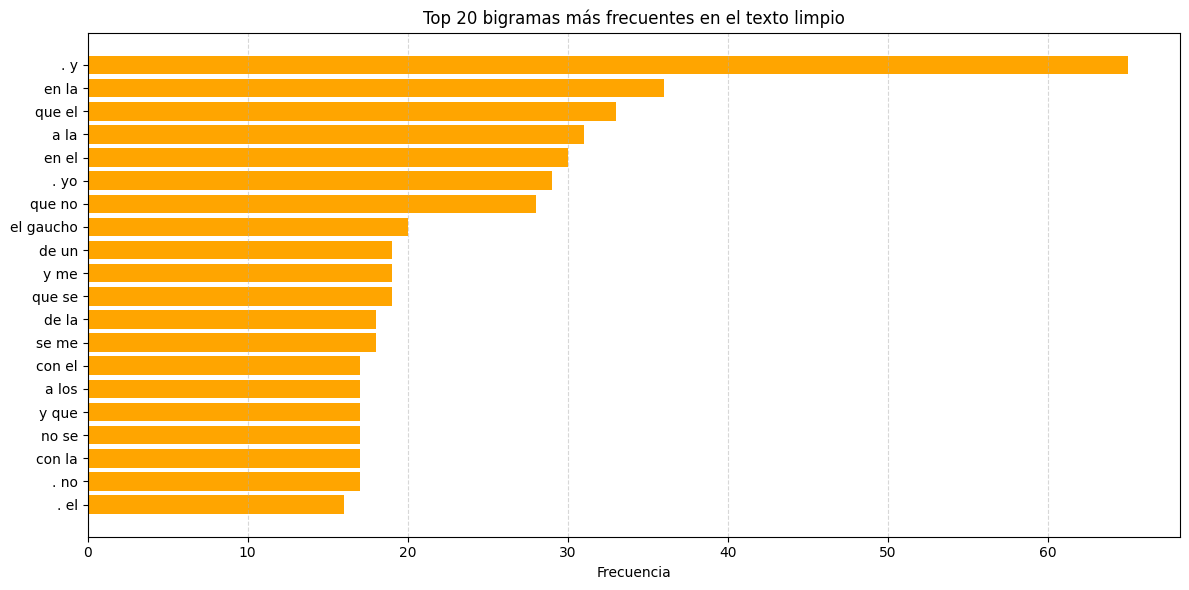

In [ ]:
etiquetas = [' '.join(par) for par, _ in top20]
frecuencias = [f for _, f in top20]

plt.figure(figsize=(12,6))
plt.barh(etiquetas, frecuencias, color='orange')
plt.title('Top 20 bigramas más frecuentes en el texto limpio')
plt.xlabel('Frecuencia')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
def limpiar_sin_puntuacion(texto):
    texto = texto.lower()
    texto = unicodedata.normalize("NFKD", texto)
    texto = ''.join(c for c in texto if not unicodedata.combining(c))
    texto = re.sub(r'[¡!¿?\"“”‘’«»,.:;]', '', texto)
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

In [ ]:
texto_sin_puntos = limpiar_sin_puntuacion(texto_limpio)



In [ ]:
# Tokenizamos el texto limpio entero
tokens2 = word_tokenize(texto_sin_puntos.lower())

In [ ]:
from nltk.util import bigrams
# Generamos bigramas
bigrs2 = list(bigrams(tokens2))

# Contamos frecuencia
conteo = Counter(bigrs2)

# Extraemos top 20
top20_ = conteo.most_common(20)

In [ ]:
for par, freq in top20_:
    print(f"{' '.join(par)}: {freq}")

en la: 36
que el: 33
a la: 31
en el: 30
que no: 28
el gaucho: 20
de un: 19
y me: 19
que se: 19
de la: 18
se me: 18
con el: 17
a los: 17
y que: 17
no se: 17
con la: 17
ni un: 16
el hombre: 15
a mi: 15
que me: 15


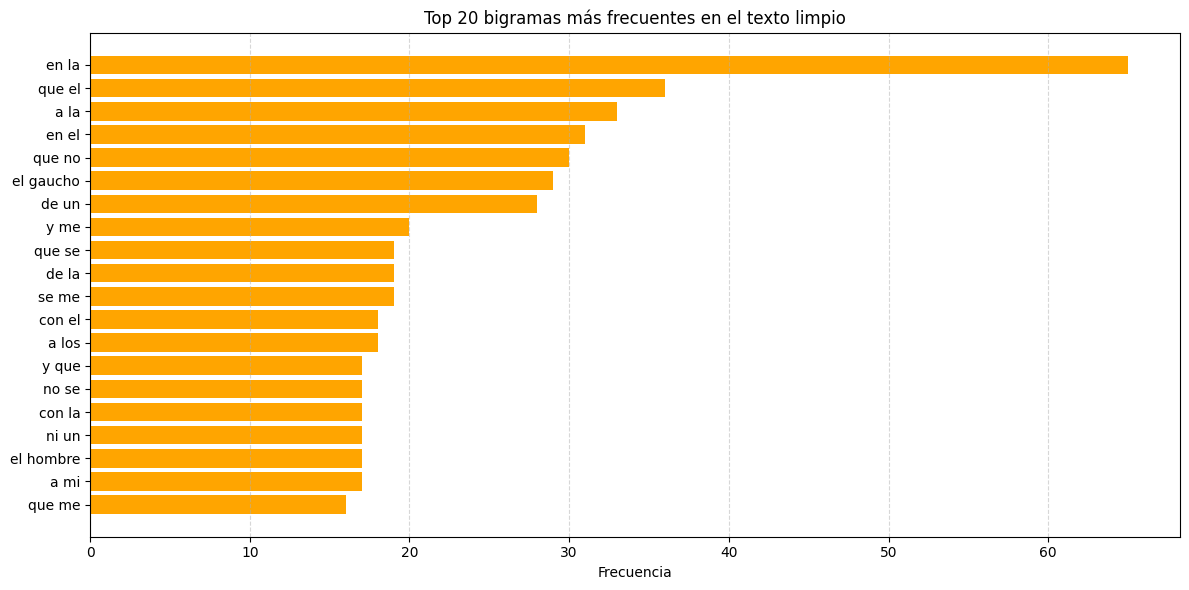

In [ ]:
etiquetas = [' '.join(par) for par, _ in top20_]
frecuencias = [f for _, f in top20]

plt.figure(figsize=(12,6))
plt.barh(etiquetas, frecuencias, color='orange')
plt.title('Top 20 bigramas más frecuentes en el texto limpio')
plt.xlabel('Frecuencia')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## 6C - Filtrado de n-gramas
* Utilizar la lista de stopwords del punto 3
* Crear una función para determinar si un n-grama es significativo
* Aplicarla a los bigramas y trigramas de 6A y 6B
* Comparar la proporción de n-gramas significativos vs. no significativos

In [ ]:
def es_significativo(ngrama):
    return all(palabra.lower() not in stop_words for palabra in ngrama)


In [ ]:
from nltk import trigrams

# Texto tokenizado
tokens = word_tokenize(texto_limpio.lower())

# Bigramas y trigramas
lista_bigrama = list(bigrams(tokens))
lista_trigrama = list(trigrams(tokens))


In [ ]:
bigr_significativos = [b for b in lista_bigrama if es_significativo(b)]
trigr_significativos = [t for t in lista_trigrama if es_significativo(t)]


In [ ]:
print(f"Bigrama total: {len(lista_bigrama)}")
print(f"Bigrama significativos: {len(bigr_significativos)}")
print(f"Proporción útil: {len(bigr_significativos)/len(lista_bigrama):.2%}")

print(f"\nTrigrama total: {len(lista_trigrama)}")
print(f"Trigrama significativos: {len(trigr_significativos)}")
print(f"Proporción útil: {len(trigr_significativos)/len(lista_trigrama):.2%}")


Bigrama total: 11785
Bigrama significativos: 2432
Proporción útil: 20.64%

Trigrama total: 11784
Trigrama significativos: 980
Proporción útil: 8.32%


## 6D - Análisis de n-gramas significativos (nombre y apellido de quien resuelve)
* Seleccionar los 15 bigramas y trigramas más significativos
* Crear una tabla comparativa
* Analizar e interpretar los resultados
* Relacionarlos con el contenido del libro


In [ ]:
# Top 15 bigramas significativos
top_bigr = Counter(bigr_significativos).most_common(15)

# Top 15 trigramas significativos
top_trigr = Counter(trigr_significativos).most_common(15)

In [ ]:
import pandas as pd

tabla = pd.DataFrame({
    "Bigrama": [' '.join(palabras) for palabras, _ in top_bigr],
    "Freq Bigrama": [freq for _, freq in top_bigr],
    "Trigrama": [' '.join(palabras) for palabras, _ in top_trigr],
    "Freq Trigrama": [freq for _, freq in top_trigr]
})

tabla


,Bigrama,Freq Bigrama,Trigrama,Freq Trigrama
0,tal vez,15,. tal vez,3
1,. si,9,mas alvertido .,2
2,. ahi,7,. pucha si,2
3,. ah,6,quise aguardar mas,2
4,. ansi,6,si habia venido,2
5,dia .,5,consuela . pido,1
6,. mas,4,entendimiento . vengan,1
7,. pues,4,. vengan santos,1
8,si uste,4,vengan santos milagrosos,1
9,. despues,4,santos milagrosos vengan,1


## 6E - N-gramas más frecuentes

* Extraiga los bigramas y trigramas más frecuentes del texto.
* Elimine aquellos n-gramas que contienen mayoritariamente stop-words.
* Presente una tabla con los 15 bigramas y trigramas más significativos.
* ¿Qué información adicional aportan estos n-gramas sobre el contenido del libro? Interprete

In [ ]:
def ngrama_significativo(ngrama, max_stopwords=1):
    return sum(1 for palabra in ngrama if palabra in stop_words) <= max_stopwords


In [ ]:
# Borramos puntuación y tokenizamos
tokens = word_tokenize(texto_sin_puntos)

# Generamos ngramas
bigrs = list(bigrams(tokens))
trigrs = list(trigrams(tokens))

# Filtramos
bigr_signif = [b for b in bigrs if ngrama_significativo(b)]
trigr_signif = [t for t in trigrs if ngrama_significativo(t)]


In [ ]:
from collections import Counter
import pandas as pd

top15_b = Counter(bigr_signif).most_common(15)
top15_t = Counter(trigr_signif).most_common(15)

tabla = pd.DataFrame({
    'Bigrama': [' '.join(b) for b, _ in top15_b],
    'Frecuencia B': [f for _, f in top15_b],
    'Trigrama': [' '.join(t) for t, _ in top15_t],
    'Frecuencia T': [f for _, f in top15_t]
})

tabla


,Bigrama,Frecuencia B,Trigrama,Frecuencia T
0,el gaucho,20,ahi no mas,13
1,el hombre,15,tal vez no,5
2,tal vez,15,del mesmo modo,3
3,lo mesmo,13,y pa mejor,3
4,ahi no,13,pego el grito,3
5,no mas,13,pongo a cantar,2
6,y si,12,cantar cantando me,2
7,mesmo que,12,agua de manantial,2
8,le dio,11,el gaucho mas,2
9,si me,10,mas malo que,2


# 7 - Visualización de relaciones entre personajes

* Utilizando los resultados anteriores (mirar 4E), cree una visualización de red que muestre las relaciones entre los personajes.
* Determine la "cercanía" entre entidades basándose en la co-ocurrencia en las mismas estrofas.
* Presente conclusiones sobre la estructura narrativa del libro basado en esta visualización.

In [ ]:
from itertools import combinations
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt

# Paso 1: Crear los pares de personajes por estrofa
coocurrencias = Counter()

for personajes1 in personajes:
    for par in combinations(sorted(set(personajes1)), 2):
        coocurrencias[par] += 1


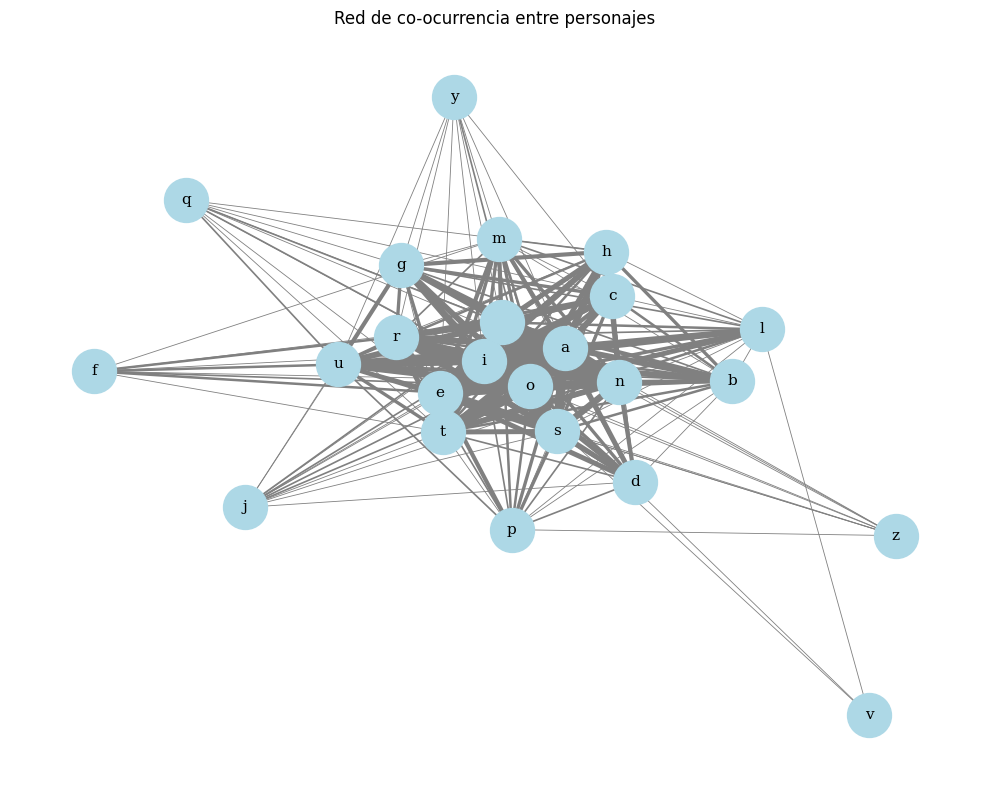

In [ ]:
# Crear el grafo
G = nx.Graph()

for (p1, p2), peso in coocurrencias.items():
    G.add_edge(p1, p2, weight=peso)

# Layout de nodos
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, k=1.2, seed=42)

# Dibujar nodos
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')

# Etiquetas de nodos
nx.draw_networkx_labels(G, pos, font_size=11, font_family='serif')

# Dibujar enlaces con grosor proporcional al peso
pesos = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_edges(G, pos, width=[w * 0.6 for w in pesos], edge_color='gray')

plt.title("Red de co-ocurrencia entre personajes")
plt.axis('off')
plt.tight_layout()
plt.show()


# 8 - Matriz TF-IDF

## 8 A - Preparación para TF-IDF
* Importar las bibliotecas necesarias (sklearn)
* Crear un vectorizador TF-IDF
* Configurar parámetros (stop_words, ngram_range, etc.)
* Aplicar el vectorizador al corpus de estrofas
* Generar la matriz TF-IDF completa
* Extraer vocabulary_ y feature_names_
* Mostrar dimensiones de la matriz resultante
* Documentar decisiones de configuración

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd


In [ ]:
vectorizador = TfidfVectorizer(
    stop_words=stop_words,     # Elimina palabras vacías
    lowercase=True,           # Convierte todo a minúsculas
    ngram_range=(1, 2),       # Unigramas y bigramas
    max_df=0.9,               # Ignora términos muy frecuentes
    min_df=2                  # Ignora términos que aparecen solo 1 vez
)


In [ ]:
matriz_tfidf = vectorizador.fit_transform(lista_estrofas)


In [ ]:
vocabulario = vectorizador.vocabulary_
terminos = vectorizador.get_feature_names_out()


In [ ]:
print("Dimensiones de la matriz TF-IDF:", matriz_tfidf.shape)


Dimensiones de la matriz TF-IDF: (435, 974)


In [ ]:
matriz_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4035 stored elements and shape (435, 974)>

In [ ]:
df_tfidf = pd.DataFrame(matriz_tfidf.toarray(), columns=terminos)
df_tfidf

,abajo,acaba,acabar,acabe,acabo,acomode,acompanao,adelante,adentro,adentros,...,vivo,vizcachera,volver,volvi,volvio,vos,voy,voz,yunta,zorro
0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.306051,0.0,0.0,0.0
2,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
431,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
432,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
433,0.0,0.0,0.0,0.35344,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
